### Position control

In [105]:
import mujoco
import mujoco_viewer
import numpy as np
import os
from lxml import etree
import lxml.etree as ET
import time

##############################################
# Helper functions for XML attribute swapping
##############################################
def swap_par(tree, element_type, element_name, attribute_name, new_value):
    """
    Swap the attribute (attribute_name) of an element (element_type) with the given name
    to new_value in the XML tree.
    """
    element = tree.find(f'.//{element_type}[@name="{element_name}"]')
    if element is not None:
        element.set(attribute_name, new_value)

##############################################
# Helper function to add a dynamic site to a body
##############################################
def add_dynamic_site(tree, body_name, site_name, pos):
    """
    Create a new site element with given name and position and append it to the body.
    """
    body_elem = tree.find(f'.//body[@name="{body_name}"]')
    if body_elem is not None:
        new_site = ET.Element("site", name=site_name, size="0.0001", pos=pos, rgba="1 0 0 1")
        body_elem.append(new_site)
    return site_name

#########################################################
# Function to generate a cantilever beam XML segment string
#########################################################
def generate_xml(ID, n):
    """
    Create an XML segment for a beam.
    ID: identifier (e.g., "F", "B", "R0", etc.)
    n: number of segments (springs) in the beam.
    """
    xml_output = []
    # Для ребер (ID начинается с "R") добавляем дополнительный free joint в начале
    n_closers = n
    if isinstance(ID, str) and ID.startswith("R"):
        xml_output.append('<body>')
        xml_output.append('<joint type="free"/>')
        n_closers += 1

    # Базовое тело для сегмента 0 с фиксированным сайтом
    xml_output.append(f'<body name="ID{ID}_b_0" pos="0 0 0" euler="0 0 0">')
    xml_output.append(f'<site name="ID{ID}_b_0_sroot" size="0.0001" pos="0 0 0"/>')
    xml_output.append(f'<geom name="ID{ID}_b_0_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
    xml_output.append(f'<site name="ID{ID}_b_0_s" size="0.0001" pos="0 0 0.05"/>')

    # Создаем остальные тела
    for i in range(1, n + 1):
        xml_output.append(f'<body name="ID{ID}_b_{i}" pos="0 0 0" euler="0 0 0">')
        xml_output.append(f'<joint name="ID{ID}_b_{i}_j" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="0" damping="0.00001"/>')
        xml_output.append(f'<geom name="ID{ID}_b_{i}_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
        xml_output.append(f'<site name="ID{ID}_b_{i}_s" size="0.0001" pos="0 0 0.05"/>')

    # Сайт на конце
    xml_output.append(f'<site name="ID{ID}_b_{n+1}_s" size="0.0001" pos="0 0 0.05"/>')

    # Закрываем все открытые теги
    for i in range(n_closers + 1):
        xml_output.append('</body>')

    return '\n'.join(xml_output)

#########################################################
# Function to update geometry and dynamic parameters in XML tree
#########################################################
def reparcer(ID, geom_pars, n, tree):
    """
    Update geometry and dynamic parameters for the beam with identifier ID.
    geom_pars: [L, b, t, alpha_k] – длина, ширина балки, толщина, коэффициент демпфирования.
    n: число сегментов.
    """
    L, b, t, alpha_k = geom_pars
    l_i = L / n
    l_0 = l_i / 2
    E = 18.5e6  # модуль Юнга
    I = t**3 * b / 12
    k_i = E * I / l_i
    d_i = k_i * alpha_k

    for i in range(0, n+1):
        if i == 0:
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_0_s', 'pos', f"0 0 {l_0/2}")
        elif i == n:
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {l_i}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
        else:
            pos = l_0 if i == 1 else l_i
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {pos}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_i/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")

    swap_par(tree, 'site', f'ID{ID}_b_{n+1}_s', 'pos', f"0 0 {l_0}")

#########################################################
# Helper function to choose beam segment for connections
#########################################################

def site_searcher(L, L_site, n):

    # Вычисляем длины участков
    li = L / n           # центральный участок
    l0 = li / 2          # первый и последний участки

    # Формируем последовательность участков: [l0, li, li, ..., li, l0]
    segments = [l0] + [li] * (n - 1) + [l0]

    cumulative = 0.0
    # Ищем участок, на котором заканчивается L_site
    for idx, seg_length in enumerate(segments):
        if cumulative + seg_length >= L_site:
            local_offset = L_site - cumulative
            return idx, local_offset
        cumulative += seg_length

    # Если L_site равен L (или очень близко), вернем последний участок
    return len(segments) - 1, segments[-1]

#########################################################
# Combined function: generate a parameterized Finray model and run simulation
#########################################################
def run_finray_simulation(
    rib_angles_deg,        # список углов ребер (в градусах)
    thickness_ribs,        # список толщин ребер (одна для каждого ребра) или None
    n_springs_front,       # число пружин для передней балки
    n_springs_back,        # число пружин для задней балки
    n_springs_rib,         # число пружин для каждого ребра
    thickness_front,       # толщина передней балки
    thickness_back,        # толщина задней балки
    thickness_rib,         # толщина ребра (если thickness_ribs равен None)
    beam_width,            # общая ширина балок
    L0,                    # длина передней балки
    X1,                    # боковое измерение для задней балки
    xf,                    # фокальная точка по оси X (для проекции)
    zf,                    # фокальная точка по оси Z
    moving_cylinder_x,     # позиция цилиндра по оси X
    moving_cylinder_z,     # позиция цилиндра по оси Z
    moving_cylinder_radius,# радиус цилиндра
    vis                    # включить визуализацию (True/False)
):
    #########################################################
    # Генерация Finray-модели
    #########################################################
    alpha_k = 5e-3
    phi_a = np.arctan((L0 - zf) / xf)
    phi_b = -np.arctan(zf / (X1 + xf))
    
    beta = np.arctan(L0 / X1)
    L1 = np.sqrt(L0**2 + X1**2)

    ribs_geom = {}
    valid_rib_indices = []
    for idx, angle_deg in enumerate(rib_angles_deg):
        phi_r = np.deg2rad(angle_deg)
        if phi_r < phi_b or phi_r > phi_a:
            #print(f"Rib {idx} with angle {angle_deg}° out of bounds, skipping.")
            continue
        L_A = zf + xf * np.tan(phi_r)
        L_B = (X1 * np.tan(phi_r) + L_A) / (np.sin(beta) + np.cos(beta) * np.tan(phi_r))
        P_A_z = L_A
        P_B_x = X1 - L_B * np.sin(0.5 * np.pi - beta)
        P_B_z = L_B * np.cos(0.5 * np.pi - beta)
        L_rib = np.sqrt((0 - P_B_x)**2 + (P_A_z - P_B_z)**2)
        alpha_rib = np.arcsin((P_B_z - P_A_z) / L_rib)
        ribs_geom[idx] = {
            'L_A': L_A, 
            'L_B': L_B, 
            'P_A_z': P_A_z, 
            'L_rib': L_rib,
            'alpha_rib': alpha_rib
        }
        valid_rib_indices.append(idx)

    xml_front = generate_xml("F", n_springs_front)
    xml_back = generate_xml("B", n_springs_back)
    xml_ribs = {}
    
    for idx in valid_rib_indices:
        xml_ribs[idx] = generate_xml(f"R{idx}", n_springs_rib)

    base_xml_path = "Finray_model.xml"
    mod_xml_path = "Finray_model_mod.xml"
    hand_tree = ET.parse(base_xml_path)
    hand_root = hand_tree.getroot()
    xml_equal = hand_root.find("equality")
    if xml_equal is not None:
        xml_equal.clear()

    worldbody = hand_root.find("worldbody")
    worldbody.append(ET.fromstring(xml_front))
    worldbody.append(ET.fromstring(xml_back))
    for idx in xml_ribs:
        worldbody.append(ET.fromstring(xml_ribs[idx]))
    
    focal_site = ET.Element("site", name="focal_site", pos=f"{-xf} 0 {zf}", size="0.001", rgba="0 1 0 0.1", type="sphere")
    worldbody.append(focal_site)
    
    for idx in valid_rib_indices:
        start = np.array([-xf, 0, zf])
        end = np.array([0, 0, ribs_geom[idx]['P_A_z']])
        vec = end - start
        length = np.linalg.norm(vec)
        midpoint = start + vec/2
        angle = np.arccos(vec[2] / length)
        q0 = np.cos(angle/2)
        q2 = np.sin(angle/2)
        quat_str = f"{q0} 0 {q2} 0"
        pos_str = f"{midpoint[0]} {midpoint[1]} {midpoint[2]}"
        focal_line = ET.Element("geom", name=f"focal_line_{idx}", type="cylinder",
                                pos=pos_str, quat=quat_str,
                                size=f"0.0005 {length/2}", rgba="0 1 0 0.1", contype="0", conaffinity="0")
        worldbody.append(focal_line)

    hand_tree.write(mod_xml_path, pretty_print=True)
    xml_path = mod_xml_path

    # Перечитываем файл, чтобы внести дальнейшие изменения
    tree = etree.parse(xml_path)
    root = tree.getroot()
    worldbody = root.find("worldbody")
        
    geom_pars_front = [L0, beam_width, thickness_front, alpha_k]
    geom_pars_back  = [L1, beam_width, thickness_back, alpha_k]
    reparcer("F", geom_pars_front, n_springs_front, tree)
    reparcer("B", geom_pars_back, n_springs_back, tree)
    for idx in valid_rib_indices:
        rib_thickness = thickness_ribs[idx] if (thickness_ribs is not None and idx < len(thickness_ribs)) else thickness_rib
        geom_pars_rib = [ribs_geom[idx]['L_rib'], beam_width, rib_thickness, alpha_k]
        reparcer(f"R{idx}", geom_pars_rib, n_springs_rib, tree)

    swap_par(tree, 'body', 'IDB_b_0', 'euler', f"0 {-np.rad2deg(0.5*np.pi - beta)} 0")
    swap_par(tree, 'body', 'IDB_b_0', 'pos', f"{X1} 0 0")

    for idx in valid_rib_indices:
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'euler', f"0 {90 - np.rad2deg(ribs_geom[idx]['alpha_rib'])} 0")
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'pos', f"0 0 {ribs_geom[idx]['P_A_z']}")

    connection_sites = {}
    for idx in valid_rib_indices:
        i_front, l_site_front = site_searcher(L0, ribs_geom[idx]['L_A'], n_springs_front)
        i_back, l_site_back = site_searcher(L1, ribs_geom[idx]['L_B'], n_springs_back)
        site_name_front = f"IDF_b_{i_front}_conn_{idx}"
        add_dynamic_site(tree, f"IDF_b_{i_front}", site_name_front, f"0 0 {l_site_front}")
        site_name_back = f"IDB_b_{i_back}_conn_{idx}"
        add_dynamic_site(tree, f"IDB_b_{i_back}", site_name_back, f"0 0 {l_site_back}")
        connection_sites[idx] = (site_name_front, site_name_back)

    equality_elem = tree.find("equality")
    if equality_elem is None:
        equality_elem = ET.Element("equality")
        root.append(equality_elem)
    weld_fin = ET.Element("weld", name="connect_fin",
                          site1=f"IDF_b_{n_springs_front + 1}_s",
                          site2=f"IDB_b_{n_springs_back + 1}_s")
    equality_elem.append(weld_fin)
    for idx in valid_rib_indices:
        site_front = connection_sites[idx][0]
        weld_rib_front = ET.Element("weld", name=f"connect_rib_A{idx}",
                                    site1=site_front,
                                    site2=f"IDR{idx}_b_0_sroot")
        equality_elem.append(weld_rib_front)
        site_back = connection_sites[idx][1]
        weld_rib_back = ET.Element("weld", name=f"connect_rib_B{idx}",
                                   site1=site_back,
                                   site2=f"IDR{idx}_b_{n_springs_rib+1}_s")
        equality_elem.append(weld_rib_back)
 
    moving_body = ET.Element("body", name="moving_cylinder", pos=f"{-moving_cylinder_x} 0 {moving_cylinder_z}", euler="90 0 0")
    moving_joint = ET.Element("joint", name="slider_joint", type="slide", axis="1 0 0", limited="true", range="-0.5 0.5")
    moving_body.insert(0, moving_joint)
    # Задаем геометрию цилиндра; параметр half_length указан как 0.1 для примера (его можно настроить при необходимости)
    moving_geom = ET.Element("geom", name="moving_cylinder_geom", type="cylinder",
                             pos="0 0 0", size=f"{moving_cylinder_radius} 0.1",
                             rgba="0.8 0.2 0.2 0.4", euler="0 0 90", condim="4", contype="1", conaffinity="15", friction="0.9 0.2 0.2", solref="0.001 2")
    moving_body.append(moving_geom)
    worldbody.append(moving_body)

    actuator_elem = root.find("actuator")
    if actuator_elem is None:
        actuator_elem = ET.Element("actuator")
        root.append(actuator_elem)
    position_elem = ET.Element("position", name="cylinder_actuator", joint="slider_joint", kp="5000", dampratio="1", ctrlrange="-0.5 0.5")
    actuator_elem.append(position_elem)
    

    tree.write(xml_path, pretty_print=True, xml_declaration=True, encoding='UTF-8')

    #########################################################
    # Run simulation
    #########################################################
    model = mujoco.MjModel.from_xml_path(xml_path)
    data = mujoco.MjData(model)
    viewer = mujoco_viewer.MujocoViewer(model, data, title="Finray", width=1200, height=800)

    sim_time = 5
    timestep = 0.001
    n_sites = n_springs_front + 2
    pos_init = np.zeros((n_sites, 2))
    pos_deform = np.zeros((n_sites, 2))
    STEP_NUM = int(sim_time / timestep)
    cylinder_actuator_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, 'cylinder_actuator')

    for i in range(STEP_NUM):
        if viewer.is_alive:

            data.ctrl[cylinder_actuator_id] =  0.8 * moving_cylinder_x
            if i == 1:
                for j in range(n_sites):
                    site_pos = data.site_xpos[j + 1]
                    pos_init[j, 0] = site_pos[0]
                    pos_init[j, 1] = site_pos[2]
            if i == STEP_NUM - 1:
                for j in range(n_sites):
                    site_pos = data.site_xpos[j + 1]
                    pos_deform[j, 0] = site_pos[0]
                    pos_deform[j, 1] = site_pos[2]
            mujoco.mj_step(model, data)
            if vis:
                viewer.render()
        else:
            break

    viewer.close()
    deformation = np.sum(np.linalg.norm(pos_deform - pos_init, axis=1))
    #print("Total deformation:", deformation)
    return deformation

import time

moving_cylinder_radius = 10e-3
moving_cylinder_x = moving_cylinder_radius
moving_cylinder_z = 30e-3

start_time = time.time()
deformation = run_finray_simulation(
    rib_angles_deg = np.arange(-90, 90, 0.15),
    thickness_ribs = None,
    n_springs_front = 20,
    n_springs_back = 10,
    n_springs_rib = 10,
    thickness_front = 2e-3,
    thickness_back = 2e-3,
    thickness_rib = 1e-3,
    beam_width = 20e-3,
    L0 = 70e-3,
    X1 = 35e-3,
    xf = 2,
    zf = 25e-3,
    moving_cylinder_x = moving_cylinder_x,
    moving_cylinder_z = moving_cylinder_z,
    moving_cylinder_radius = moving_cylinder_radius,
    vis = True
)

end_time = time.time()

elapsed_time = end_time - start_time
#print(f"Время моделирования: {elapsed_time:.4f} секунд")


### Force control

In [ ]:
import mujoco
import mujoco_viewer
import numpy as np
import os
from lxml import etree
import lxml.etree as ET
import time

##############################################
# Helper functions for XML attribute swapping
##############################################
def swap_par(tree, element_type, element_name, attribute_name, new_value):
    element = tree.find(f'.//{element_type}[@name="{element_name}"]')
    if element is not None:
        element.set(attribute_name, new_value)

##############################################
# Helper function to add a dynamic site to a body
##############################################
def add_dynamic_site(tree, body_name, site_name, pos):
    body_elem = tree.find(f'.//body[@name="{body_name}"]')
    if body_elem is not None:
        new_site = ET.Element("site", name=site_name, size="0.0001", pos=pos, rgba="1 0 0 1")
        body_elem.append(new_site)
    return site_name

#########################################################
# Function to generate a cantilever beam XML segment string
#########################################################
def generate_xml(ID, n):
    xml_output = []
    n_closers = n
    if isinstance(ID, str) and ID.startswith("R"):
        xml_output.append('<body>')
        xml_output.append('<joint type="free"/>')
        n_closers += 1
    xml_output.append(f'<body name="ID{ID}_b_0" pos="0 0 0" euler="0 0 0">')
    xml_output.append(f'<site name="ID{ID}_b_0_sroot" size="0.0001" pos="0 0 0"/>')
    xml_output.append(f'<geom name="ID{ID}_b_0_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
    xml_output.append(f'<site name="ID{ID}_b_0_s" size="0.0001" pos="0 0 0.05"/>')
    for i in range(1, n + 1):
        xml_output.append(f'<body name="ID{ID}_b_{i}" pos="0 0 0" euler="0 0 0">')
        xml_output.append(f'<joint name="ID{ID}_b_{i}_j" type="hinge" axis="0 1 0" pos="0 0 0" stiffness="0" damping="0.00001"/>')
        xml_output.append(f'<geom name="ID{ID}_b_{i}_g" type="box" size="0.0005 0.005 0.01" pos="0 0 0.01" rgba="0.1 0.1 0.1 0.5"/>')
        xml_output.append(f'<site name="ID{ID}_b_{i}_s" size="0.0001" pos="0 0 0.05"/>')
    xml_output.append(f'<site name="ID{ID}_b_{n+1}_s" size="0.0001" pos="0 0 0.05"/>')
    for i in range(n_closers + 1):
        xml_output.append('</body>')
    return '\n'.join(xml_output)

#########################################################
# Function to update geometry and dynamic parameters in XML tree
#########################################################
def reparcer(ID, geom_pars, n, tree):
    L, b, t, alpha_k = geom_pars
    l_i = L / n
    l_0 = l_i / 2
    E = 18.5e6
    I = t**3 * b / 12
    k_i = E * I / l_i
    d_i = k_i * alpha_k
    for i in range(0, n+1):
        if i == 0:
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_0_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_0_s', 'pos', f"0 0 {l_0/2}")
        elif i == n:
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {l_i}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_0/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_0/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
        else:
            pos = l_0 if i == 1 else l_i
            swap_par(tree, 'body', f'ID{ID}_b_{i}', 'pos', f"0 0 {pos}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'size', f"{t/2} {b/2} {l_i/2}")
            swap_par(tree, 'geom', f'ID{ID}_b_{i}_g', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'site', f'ID{ID}_b_{i}_s', 'pos', f"0 0 {l_i/2}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'stiffness', f"{k_i}")
            swap_par(tree, 'joint', f'ID{ID}_b_{i}_j', 'damping', f"{d_i}")
            swap_par(tree, 'site', f'ID{ID}_b_{n+1}_s', 'pos', f"0 0 {l_0}")

def site_searcher(L, L_site, n):
    li = L / n
    l0 = li / 2
    segments = [l0] + [li] * (n - 1) + [l0]
    cumulative = 0.0
    for idx, seg_length in enumerate(segments):
        if cumulative + seg_length >= L_site:
            local_offset = L_site - cumulative
            return idx, local_offset
        cumulative += seg_length
    return len(segments) - 1, segments[-1]

#########################################################
# Combined function: generate a parameterized Finray model and run simulation
#########################################################
def run_finray_simulation(
    rib_angles_deg,
    thickness_ribs,
    n_springs_front,
    n_springs_back,
    n_springs_rib,
    thickness_front,
    thickness_back,
    thickness_rib,
    beam_width,
    L0,
    X1,
    xf,
    zf,
    moving_cylinder_x,
    moving_cylinder_z,
    moving_cylinder_radius,
    moving_cylinder_force,
    vis
):
    alpha_k = 5e-3
    phi_a = np.arctan((L0 - zf) / xf)
    phi_b = -np.arctan(zf / (X1 + xf))
    beta = np.arctan(L0 / X1)
    L1 = np.sqrt(L0**2 + X1**2)

    ribs_geom = {}
    valid_rib_indices = []
    for idx, angle_deg in enumerate(rib_angles_deg):
        phi_r = np.deg2rad(angle_deg)
        if phi_r < phi_b or phi_r > phi_a:
            continue
        L_A = zf + xf * np.tan(phi_r)
        L_B = (X1 * np.tan(phi_r) + L_A) / (np.sin(beta) + np.cos(beta) * np.tan(phi_r))
        P_A_z = L_A
        P_B_x = X1 - L_B * np.sin(0.5 * np.pi - beta)
        P_B_z = L_B * np.cos(0.5 * np.pi - beta)
        L_rib = np.sqrt((0 - P_B_x)**2 + (P_A_z - P_B_z)**2)
        alpha_rib = np.arcsin((P_B_z - P_A_z) / L_rib)
        ribs_geom[idx] = {'L_A': L_A, 'L_B': L_B, 'P_A_z': P_A_z, 'L_rib': L_rib, 'alpha_rib': alpha_rib}
        valid_rib_indices.append(idx)
    valid_rib_indices = [idx for idx in valid_rib_indices if ribs_geom[idx]['P_A_z'] >= 0]

    xml_front = generate_xml("F", n_springs_front)
    xml_back = generate_xml("B", n_springs_back)
    xml_ribs = {idx: generate_xml(f"R{idx}", n_springs_rib) for idx in valid_rib_indices}

    base_xml_path = "Finray_model.xml"
    mod_xml_path = "Finray_model_mod.xml"
    hand_tree = ET.parse(base_xml_path)
    hand_root = hand_tree.getroot()
    eq = hand_root.find("equality")
    if eq is not None:
        eq.clear()

    worldbody = hand_root.find("worldbody")
    worldbody.append(ET.fromstring(xml_front))
    worldbody.append(ET.fromstring(xml_back))
    for xml in xml_ribs.values():
        worldbody.append(ET.fromstring(xml))
    focal_site = ET.Element("site", name="focal_site", pos=f"{-xf} 0 {zf}", size="0.001", rgba="0 1 0 0.1", type="sphere")
    worldbody.append(focal_site)

    for idx in valid_rib_indices:
        start = np.array([-xf, 0, zf])
        end = np.array([0, 0, ribs_geom[idx]['P_A_z']])
        vec = end - start
        length = np.linalg.norm(vec)
        midpoint = start + vec/2
        angle = np.arccos(vec[2] / length)
        q0, q2 = np.cos(angle/2), np.sin(angle/2)
        geom = ET.Element("geom", name=f"focal_line_{idx}", type="cylinder",
                          pos=f"{midpoint[0]} {midpoint[1]} {midpoint[2]}",
                          quat=f"{q0} 0 {q2} 0",
                          size=f"0.0005 {length/2}", rgba="0 1 0 0.1", contype="0", conaffinity="0")
        worldbody.append(geom)

    hand_tree.write(mod_xml_path, pretty_print=True)
    tree = etree.parse(mod_xml_path)
    root = tree.getroot()
    worldbody = root.find("worldbody")

    # Update beam parameters
    reparcer("F", [L0, beam_width, thickness_front, alpha_k], n_springs_front, tree)
    reparcer("B", [L1, beam_width, thickness_back, alpha_k], n_springs_back, tree)
    for idx in valid_rib_indices:
        rib_t = thickness_ribs[idx] if thickness_ribs and idx < len(thickness_ribs) else thickness_rib
        reparcer(f"R{idx}", [ribs_geom[idx]['L_rib'], beam_width, rib_t, alpha_k], n_springs_rib, tree)

    # Position back beam
    swap_par(tree, 'body', 'IDB_b_0', 'euler', f"0 {-np.rad2deg(0.5*np.pi - beta)} 0")
    swap_par(tree, 'body', 'IDB_b_0', 'pos', f"{X1} 0 0")
    # Position ribs
    for idx in valid_rib_indices:
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'euler', f"0 {90 - np.rad2deg(ribs_geom[idx]['alpha_rib'])} 0")
        swap_par(tree, 'body', f'IDR{idx}_b_0', 'pos', f"0 0 {ribs_geom[idx]['P_A_z']}")

    # Connections
    conn_sites = {}
    for idx in valid_rib_indices:
        i_f, l_f = site_searcher(L0, ribs_geom[idx]['L_A'], n_springs_front)
        i_b, l_b = site_searcher(L1, ribs_geom[idx]['L_B'], n_springs_back)
        sf, sb = f"IDF_b_{i_f}_conn_{idx}", f"IDB_b_{i_b}_conn_{idx}"
        add_dynamic_site(tree, f"IDF_b_{i_f}", sf, f"0 0 {l_f}")
        add_dynamic_site(tree, f"IDB_b_{i_b}", sb, f"0 0 {l_b}")
        conn_sites[idx] = (sf, sb)

    eq = tree.find("equality")
    if eq is None:
        eq = ET.SubElement(root, "equality")
    eq.append(ET.Element("weld", name="connect_fin", site1=f"IDF_b_{n_springs_front+1}_s", site2=f"IDB_b_{n_springs_back+1}_s"))
    for idx in valid_rib_indices:
        sf, sb = conn_sites[idx]
        eq.append(ET.Element("weld", name=f"connect_rib_A{idx}", site1=sf, site2=f"IDR{idx}_b_0_sroot"))
        eq.append(ET.Element("weld", name=f"connect_rib_B{idx}", site1=sb, site2=f"IDR{idx}_b_{n_springs_rib+1}_s"))

    # Moving cylinder body, joint, geom and force site
    moving_body = ET.Element("body", name="moving_cylinder", pos=f"{-moving_cylinder_x} 0 {moving_cylinder_z}", euler="90 0 0")
    moving_joint = ET.Element("joint", name="slider_joint", type="slide", axis="1 0 0", limited="true", range="-0.5 0.5")
    
    moving_body.insert(0, moving_joint)
    moving_geom = ET.Element("geom", name="moving_cylinder_geom", type="cylinder",
                             pos="0 0 0", size=f"{moving_cylinder_radius} 0.1",
                             rgba="0.8 0.2 0.2 0.4", euler="0 0 90",
                             condim="4", contype="1", conaffinity="15",
                             friction="0.9 0.2 0.2", solref="0.001 2")
    moving_body.append(moving_geom)
    # Add site for force-based actuator
    moving_site = ET.Element("site", name="cylinder_site", pos="0 0 0", size="0.001", rgba="0 0 1 1")
    moving_body.append(moving_site)
    worldbody.append(moving_body)

    # Define general (force) actuator
    actuator_elem = root.find("actuator") or ET.SubElement(root, "actuator")
    actuator_elem.clear()
    general_elem = ET.Element("general", name="applied_force", site="cylinder_site", gear="1 0 0")
    actuator_elem.append(general_elem)

    tree.write(mod_xml_path, pretty_print=True, xml_declaration=True, encoding='UTF-8')

    #########################################################
    # Run simulation
    #########################################################
    model = mujoco.MjModel.from_xml_path(mod_xml_path)
    data = mujoco.MjData(model)
    viewer = mujoco_viewer.MujocoViewer(model, data, title="Finray (Force Control)", width=1200, height=800)

    sim_time = 20
    timestep = 0.001
    n_sites = n_springs_front + 2
    pos_init = np.zeros((n_sites, 2))
    pos_deform = np.zeros((n_sites, 2))
    STEP_NUM = int(sim_time / timestep)
    
    total_fx = 0.0
    total_fy = 0.0
    total_fz = 0.0
    
    contact_points_X = []
    contact_points_Z = []
    
    contact_forces_X = []
    contact_forces_Z = []

    force_act_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_ACTUATOR, 'applied_force')

    for i in range(STEP_NUM):
        if not viewer.is_alive:
            break
        data.ctrl[force_act_id] = moving_cylinder_force
        if i == 1:
            for j in range(n_sites):
                p = data.site_xpos[j+1]
                pos_init[j] = [p[0], p[2]]
        if i == STEP_NUM-1:
            for j in range(n_sites):
                p = data.site_xpos[j+1]
                pos_deform[j] = [p[0], p[2]]
        mujoco.mj_step(model, data)
        
        # Сбор данных только в последнем кадре
        if i == STEP_NUM - 1:
            for contact_idx in range(data.ncon):
                contact = data.contact[contact_idx]
                
                # Extract contact points
                pos = np.array(contact.pos)
                contact_points_X.append(pos[0])
                contact_points_Z.append(pos[2])
                
                
                
                # Extract contact forces
                ft = np.zeros(6)
                mujoco.mj_contactForce(model, data, contact_idx, ft)
                contact_xmat = np.array(contact.frame).reshape(3,3).T
                world_f = contact_xmat @ ft[:3]
                contact_forces_X.append(world_f[0])
                contact_forces_Z.append(world_f[2])
                
                
                # Метод 1
                # Извлекаем оси контактного кадра
                #axis_x = contact.frame[3:6]  # tangent1 (локальная X)
                #axis_y = contact.frame[6:9]  # tangent2 (локальная Y)
                #axis_z = contact.frame[0:3]  # normal (локальная Z)
                
                #fx = ft[0]*axis_x[0] + ft[1]*axis_y[0] + ft[2]*axis_z[0]
                #fy = ft[0]*axis_x[1] + ft[1]*axis_y[1] + ft[2]*axis_z[1]
                #fz = ft[0]*axis_x[2] + ft[1]*axis_y[2] + ft[2]*axis_z[2]
                
                #total_fx1 += fx
                #total_fy1 += fy
                #total_fz1 += fz
                
                # Метод 2
                # Extract contact forces
                #contact_xmat = np.array(contact.frame).reshape(3,3).T
                #world_f = contact_xmat @ ft[:3]
                #total_fx += world_f[0]
                #total_fy += world_f[1]
                #total_fz += world_f[2]
                
                
      
        if vis:
            viewer.render()

    viewer.close()
    deformation = np.sum(np.linalg.norm(pos_deform - pos_init, axis=1))
    return deformation, contact_forces_X, contact_forces_Z, contact_points_X, contact_points_Z

# Example call
if __name__ == "__main__":
    
    beam_width = 15e-3
    
    moving_cylinder_radius = 40e-3
    moving_cylinder_x = moving_cylinder_radius
    moving_cylinder_z = 35e-3
    
    moving_cylinder_force = 2
    
    start_time = time.time()
    
    deformation, con_Fx, con_Fz, con_Px, con_Pz = run_finray_simulation(
        rib_angles_deg=np.arange(-90, 90, 0.2),
        thickness_ribs=None,
        n_springs_front=20,
        n_springs_back=10,
        n_springs_rib=10,
        thickness_front=2e-3,
        thickness_back=2e-3,
        thickness_rib=1e-3,
        beam_width=beam_width,
        L0=70e-3,
        X1=35e-3,
        xf=2,
        zf=-1000e-3,
        moving_cylinder_x=moving_cylinder_x,
        moving_cylinder_z=moving_cylinder_z,
        moving_cylinder_radius=moving_cylinder_radius,
        moving_cylinder_force=moving_cylinder_force,
        vis=True
    )
    #print(f"Total deformation: {deformation}")
   
    print(f"Contact points X:, {con_Px}, m")
    print(f"Contact points Z:, {con_Pz}, m")
    
    print(f"Contact forces X:, {con_Fx}, N")
    print(f"Contact forces Z:, {con_Fz}, N")
    
    print(f"Sum of contact forces X:, {sum(con_Fx)}, N")
    print(f"Sum of contact forces Z:, {sum(con_Fz)}, N")
    
    #print(f"Simulation time: {time.time() - start_time:.4f} s")    


C:\Users\earak\AppData\Local\Temp\ipykernel_4116\857835332.py:232: FutureWarning: The behavior of this method will change in future versions. Use specific 'len(elem)' or 'elem is not None' test instead.
  actuator_elem = root.find("actuator") or ET.SubElement(root, "actuator")


Contact points X:, [], m
Contact points Z:, [], m
Contact forces X:, [], N
Contact forces Z:, [], N
Sum of contact forces X:, 0, N
Sum of contact forces Z:, 0, N


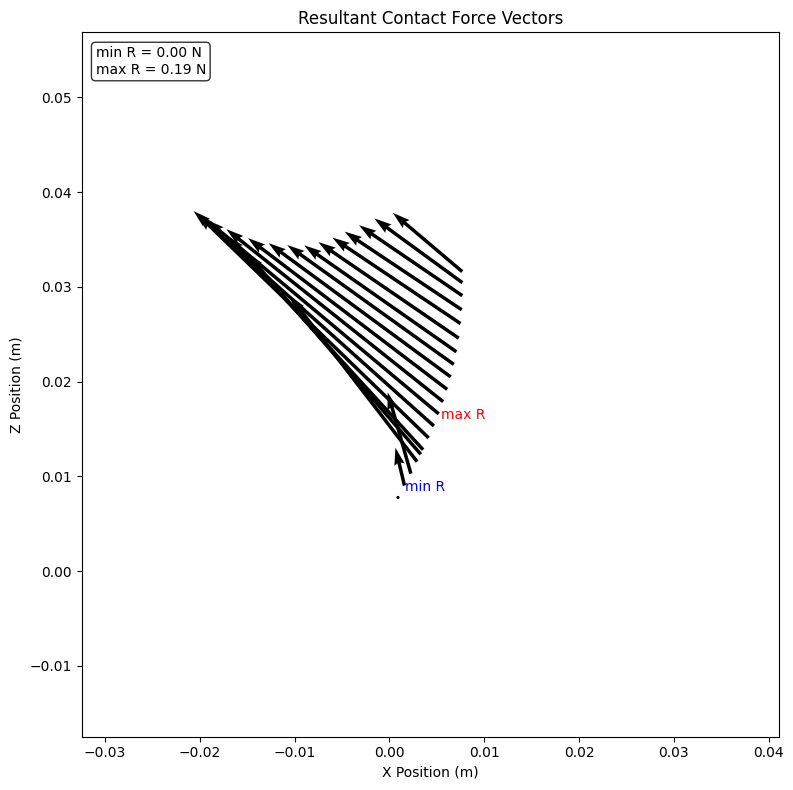

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Assume con_Px, con_Pz, con_Fx, con_Fz are defined lists or arrays

# 1. Compute resultant magnitudes R
Fx = np.array(con_Fx)
Fz = np.array(con_Fz)
R  = np.sqrt(Fx**2 + Fz**2)

# 2. Compute unit directions (avoid div by zero)

ux = np.divide(Fx, R, out=np.zeros_like(Fx), where=R>0)
uz = np.divide(Fz, R, out=np.zeros_like(Fz), where=R>0)

# 3. Determine plot spans
x_min, x_max = np.min(con_Px), np.max(con_Px)
z_min, z_max = np.min(con_Pz), np.max(con_Pz)
x_span = x_max - x_min
z_span = z_max - z_min

# 4. Choose max arrow length to be, say, 10% of the smaller span
max_len = 5 * min(x_span, z_span)

# 5. Normalize all resultants to that max length
lengths = (R / R.max()) * max_len

# 6. Compute arrow deltas and flip direction (negate)
dx = -ux * lengths
dz = -uz * lengths

# 7. Plot
fig, ax = plt.subplots(figsize=(8, 8))
q = ax.quiver(con_Px, con_Pz, dx, dz,
              angles='xy', scale_units='xy', scale=1,
              width=0.005)

ax.axis('equal')
ax.set_xlim(x_min - max_len, x_max + max_len)
ax.set_ylim(z_min - max_len, z_max + max_len)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Z Position (m)')
ax.set_title('Resultant Contact Force Vectors')

# 8. Annotate smallest and largest magnitudes
i_min = np.argmin(R)
i_max = np.argmax(R)
ax.annotate('min R', (con_Px[i_min], con_Pz[i_min]),
            textcoords="offset points", xytext=(5,5), color='blue')
ax.annotate('max R', (con_Px[i_max], con_Pz[i_max]),
            textcoords="offset points", xytext=(5,5), color='red')

# 9. Legend box
ax.text(0.02, 0.98,
        f'min R = {R.min():.2f} N\nmax R = {R.max():.2f} N',
        transform=ax.transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


In [7]:
# 1. Convert to numpy arrays (if not already)
x = np.array(con_Px, dtype=float)
z = np.array(con_Pz, dtype=float)

# 2. Compute pairwise distances and sum them
dx = np.diff(x)
dz = np.diff(z)
segment_lengths = np.sqrt(dx**2 + dz**2)
con_len = np.sum(segment_lengths)   # total curve length

# 3. Contact area
con_S = con_len * beam_width

print(f"Curve length  = {con_len:.6f} m")
print(f"Contact area  = {con_S:.6f} m2")

Curve length  = 0.025140 m
Contact area  = 0.000503 m2
